In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, t
from scipy.optimize import minimize
from scipy.linalg import cholesky, eigvals
from scipy import stats
from scipy.optimize import minimize 
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
import time
# Load data from CSV
data = pd.read_csv('problem1.csv', usecols=['x'])['x'].to_numpy()

# Calculate VaR and ES for Normal distribution
def calc_var_es_normal(returns, n=10000, alpha=0.05):
    mu = np.mean(returns)
    sigma = np.std(returns)
    simu_returns = norm.rvs(mu, sigma, size=n)
    simu_returns.sort()
    n = alpha * simu_returns.size
    iup = int(np.ceil(n))
    idn = int(np.floor(n))
    VaR = (simu_returns[iup] + simu_returns[idn]) / 2
    ES = np.mean(simu_returns[0:idn])
    return -VaR, -ES, simu_returns

# Define negative log-likelihood function for t distribution
def neg_log_likelihood_t(params, returns):
    df, loc, scale = params
    return -1 * np.sum(t.logpdf(returns, df=df, loc=loc, scale=scale))

# Calculate VaR and ES for t distribution
def calc_var_es_t(returns, n=10000, alpha=0.05):
    constraints = [
        {'type': 'ineq', 'fun': lambda x: x[0] - 1},
        {'type': 'ineq', 'fun': lambda x: x[2]}
    ]
    
    res = minimize(neg_log_likelihood_t, x0=[10, np.mean(returns), np.std(returns)], args=(returns,), constraints=constraints)
    
    df, loc, scale = res.x
    simu_returns = t.rvs(df, loc=loc, scale=scale, size=n)
    simu_returns.sort()
    n = alpha * simu_returns.size
    iup = int(np.ceil(n))
    idn = int(np.floor(n))
    VaR = (simu_returns[iup] + simu_returns[idn]) / 2
    ES = np.mean(simu_returns[0:idn])
    return -VaR, -ES, simu_returns







In [2]:
# Calculate VaR and ES for both distributions
VaR_norm, ES_norm, simu_norm = calc_var_es_normal(data)
VaR_t, ES_t, simu_t = calc_var_es_t(data)

# Print results
print(f"VaR_norm = {VaR_norm:.5f}, ES_norm = {ES_norm:.5f}")
print(f"VaR_t = {VaR_t:.5f}, ES_t = {ES_t:.5f}")

VaR_norm = 0.07993, ES_norm = 0.10025
VaR_t = 0.07518, ES_t = 0.11176


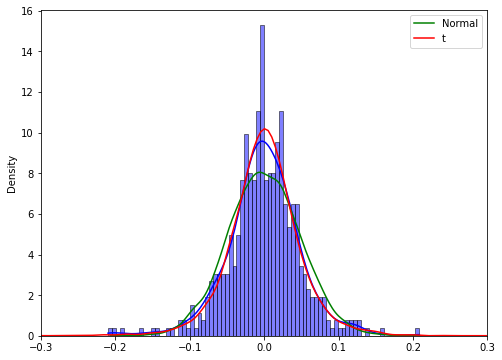

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data, bins=80, kde=True, stat='density', ax=ax, color='blue', alpha=0.5)
sns.kdeplot(simu_norm, label='Normal', color='green', ax=ax)
sns.kdeplot(simu_t, label='t', color='red', ax=ax)
ax.set_xlim(-0.3, 0.3)
ax.legend()
plt.show()


In [4]:
import library

In [5]:
#2.1
return_data = np.genfromtxt('DailyPrices.csv', delimiter=',').T
return_data = np.delete(return_data, 0, 0)
return_data = np.delete(return_data, 0, 1)
return_data = np.matrix(np.fliplr(return_data))
weights = library.calculate_exponential_weights(return_data.shape[1], lamb=0.97)
print(weights.shape)

ew_cov = library.calculate_ewcov(return_data, lamb=0.97)
print(ew_cov.shape)

(249,)
(249, 249)


In [6]:
#2.2
n = 500
sigma = np.full((n,n),0.9)
for i in range(n):
    sigma[i,i]=1.0
sigma[0,1] = 0.7357
sigma[1,0] = 0.7357

In [7]:
print("Sigma with near_psd(): ", library.is_psd(library.near_psd(sigma)))
print("Sigma with Higham_psd(): ", library.is_psd(library.Higham_psd(sigma)))

Sigma with near_psd():  True
Sigma with Higham_psd():  True


In [8]:
#2.3
n = 500
sigma = np.full((n, n), 0.9)
np.fill_diagonal(sigma, 1.0)
sigma[0, 1] = 0.7357
sigma[1, 0] = 0.7357

ew_cov = library.calculate_ewcov(sigma, lamb=0.94)

res_d = library.direct_simulation(ew_cov, n_samples=25000)
res_pca = library.pca_simulation(ew_cov, pct_explained=0.75, n_samples=25000)
print(res_d.shape)
print(res_pca.shape)

(500, 25000)
(500, 25000)


In [9]:
#2.4
sample_return = (return_data[0] - return_data[0].mean()).T
sample = np.random.normal(1,0)
mu = 0  # mean of the normal distribution
sigma = 1  # standard deviation of the normal distribution
rv = np.random.normal(mu, sigma)  # create a random variable from the normal distribution

var_norm = library.normal_var(sample_return)
var_ew_norm = library.ewcov_normal_var(sample_return)
var_t = library.t_var(sample_return)
var_hist = library.historic_var(rv)

print("Normal VaR:", var_norm)
print("Exponentially Weighted Normal VaR:", var_ew_norm)
print("Student's t VaR:", var_t)
print("Historical VaR:", var_hist)


Normal VaR: 37.2251497585685
Exponentially Weighted Normal VaR: 0.0
Student's t VaR: 36.97691114169762
Historical VaR: -0.09661060033085396


In [10]:
#2.5
es = library.calculate_es(sample)
print(es)

-1.0


In [11]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import t

def calculate_var(data, mean=0, alpha=0.05):
    # Calculate the value-at-risk (VaR) of a given data set at a specified confidence level
    return mean - np.quantile(data, alpha)

def calculate_es(data, mean=0, alpha=0.05):
    # Calculate the expected shortfall (ES) of a given data set at a specified confidence level
    var = calculate_var(data, mean, alpha)
    return -np.mean(data[data <= -var])

def pd_calculate_returns(prices, method="arithmetic"):
    price_change_percent = (prices / prices.shift(1))[1:]
    if method == "arithmetic":
        return price_change_percent - 1
    elif method == "log":
        return np.log(price_change_percent)

# load in data and calculate returns
prices = pd.read_csv("DailyPrices.csv", parse_dates=[0], index_col=0)
portfolios = pd.read_csv("portfolio.csv")
returns = pd_calculate_returns(prices)

# Combine the portfolios to get a total one and append it to the end for easier calculation.
total_holdings = portfolios.groupby('Stock').sum('Holding')
total_holdings['Portfolio'] = 'Total'
total_holdings = total_holdings.reset_index()
portfolios = portfolios.append(total_holdings)

t_params = {}
hist_data = []
sim_data = []
for col in returns:
    stock_returns = returns[col]
    # we assume the expected return is 0
    stock_returns -= stock_returns.mean()
    hist_data.append(stock_returns)
    # fit a generalized t distribution to each stock
    result = t.fit(stock_returns, method="MLE")
    df, loc, scale = result
    t_params[col] = [df, loc, scale]
    # simulate based on t distribution for each stock
    sim_data.append(t(df, loc, scale).rvs(10000))
hist_data = np.array(hist_data)
sim_data = np.array(sim_data)

# create pandas dataframe for the returns
historical_returns = pd.DataFrame(columns=returns.columns, data=hist_data.T)
simulated_returns = pd.DataFrame(columns=returns.columns, data=sim_data.T)

# for historical data
current_prices = pd.DataFrame({"Price":prices.iloc[-1]})

for portfolio_index, portfolio in portfolios.groupby('Portfolio'):
    portfolio = portfolio.set_index('Stock')
    portfolio = portfolio.join(current_prices.loc[portfolio.index])

    hist_returns = historical_returns[portfolio.index]
    sim_prices_change = hist_returns * portfolio['Price'].T
    sim_values_change = sim_prices_change @ portfolio['Holding']

    historic_var = calculate_var(sim_values_change)
    historic_es = calculate_es(sim_values_change)
    print(f"Portfolio {portfolio_index} " + "VaR: " + str(historic_var))
    print(f"Portfolio {portfolio_index} " + "ES: " + str(historic_es))
    print()


/tmp/ipykernel_3203/7812330.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  portfolios = portfolios.append(total_holdings)


Portfolio A VaR: 8805.507754785509
Portfolio A ES: 10438.09016614881

Portfolio B VaR: 6981.307577790557
Portfolio B ES: 8945.79531744502

Portfolio C VaR: 5496.294533012176
Portfolio C ES: 7436.626667146727

Portfolio Total VaR: 21076.418322771402
Portfolio Total ES: 26687.791306205952



In [12]:
for portfolio_index, portfolio in portfolios.groupby('Portfolio'):
  portfolio = portfolio.set_index('Stock')
  portfolio = portfolio.join(current_prices.loc[portfolio.index])

  sim_returns = simulated_returns[portfolio.index]
  sim_prices_change = sim_returns * portfolio['Price'].T
  sim_values_change = sim_prices_change @ portfolio['Holding']

  sim_var = library.calculate_var(sim_values_change)
  sim_es = library.calculate_es(sim_values_change)
  print(f"Portfolio {portfolio_index} " + "VaR: " + str(sim_var))
  print(f"Portfolio {portfolio_index} " + "ES: " + str(sim_es))
  print()


Portfolio A VaR: 1877.1408461763208
Portfolio A ES: 1877.1408461763208

Portfolio B VaR: 1869.1578218921422
Portfolio B ES: 1869.1578218921422

Portfolio C VaR: 1589.7015996204807
Portfolio C ES: 1589.7015996204807

Portfolio Total VaR: 3083.318415961621
Portfolio Total ES: 3083.318415961621

